# Posterior Analysis

In this tutorial, we use `WaveformUncertainty` to examine the results of two parameter estimation runs: one that performed the waveform uncertainty correction and one that did not.

The following cell is everything we need to import to run this tutorial. We also import the `WaveformUncertainty` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [2]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import lal
import pesummary
import scipy
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import WaveformUncertainty as wfu

We start by loading in the result files from two low-resolution parameter estimation runs. We will refer to the run that did the correction as "WFU_result" (WFU for 'waveform uncertainty') and the one that did not will be "NHP_result" (NHP for 'null-hypothesis').

Note: To save computing time, only the phase correction was done on the corrected posterior, so while they were injected into the waveform, no $\alpha$ parameters are present in its posterior.

In [15]:
# downloading the files and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file1 = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/BNS_wfu_nlive_100_result.json', allow_redirects=True)
file2 = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/BNS_nhp_nlive_100_result.json', allow_redirects=True)
open("tutorial_files/WFU_result.json", 'wb').write(file1.content)
open("tutorial_files/NHP_result.json",'wb').write(file2.content)

WFU_result = bilby.read_in_result('tutorial_files/WFU_result.json')
NHP_result = bilby.read_in_result('tutorial_files/NHP_result.json')

## Corner Plots

Because both runs contain the same binary neutron star source parameters, we can plot the posterior distributions of each on the same corner plot to obeserve the effects of the correction. We color the null-hypothesis posterior red and the waveform uncertainty corrected posterior blue.

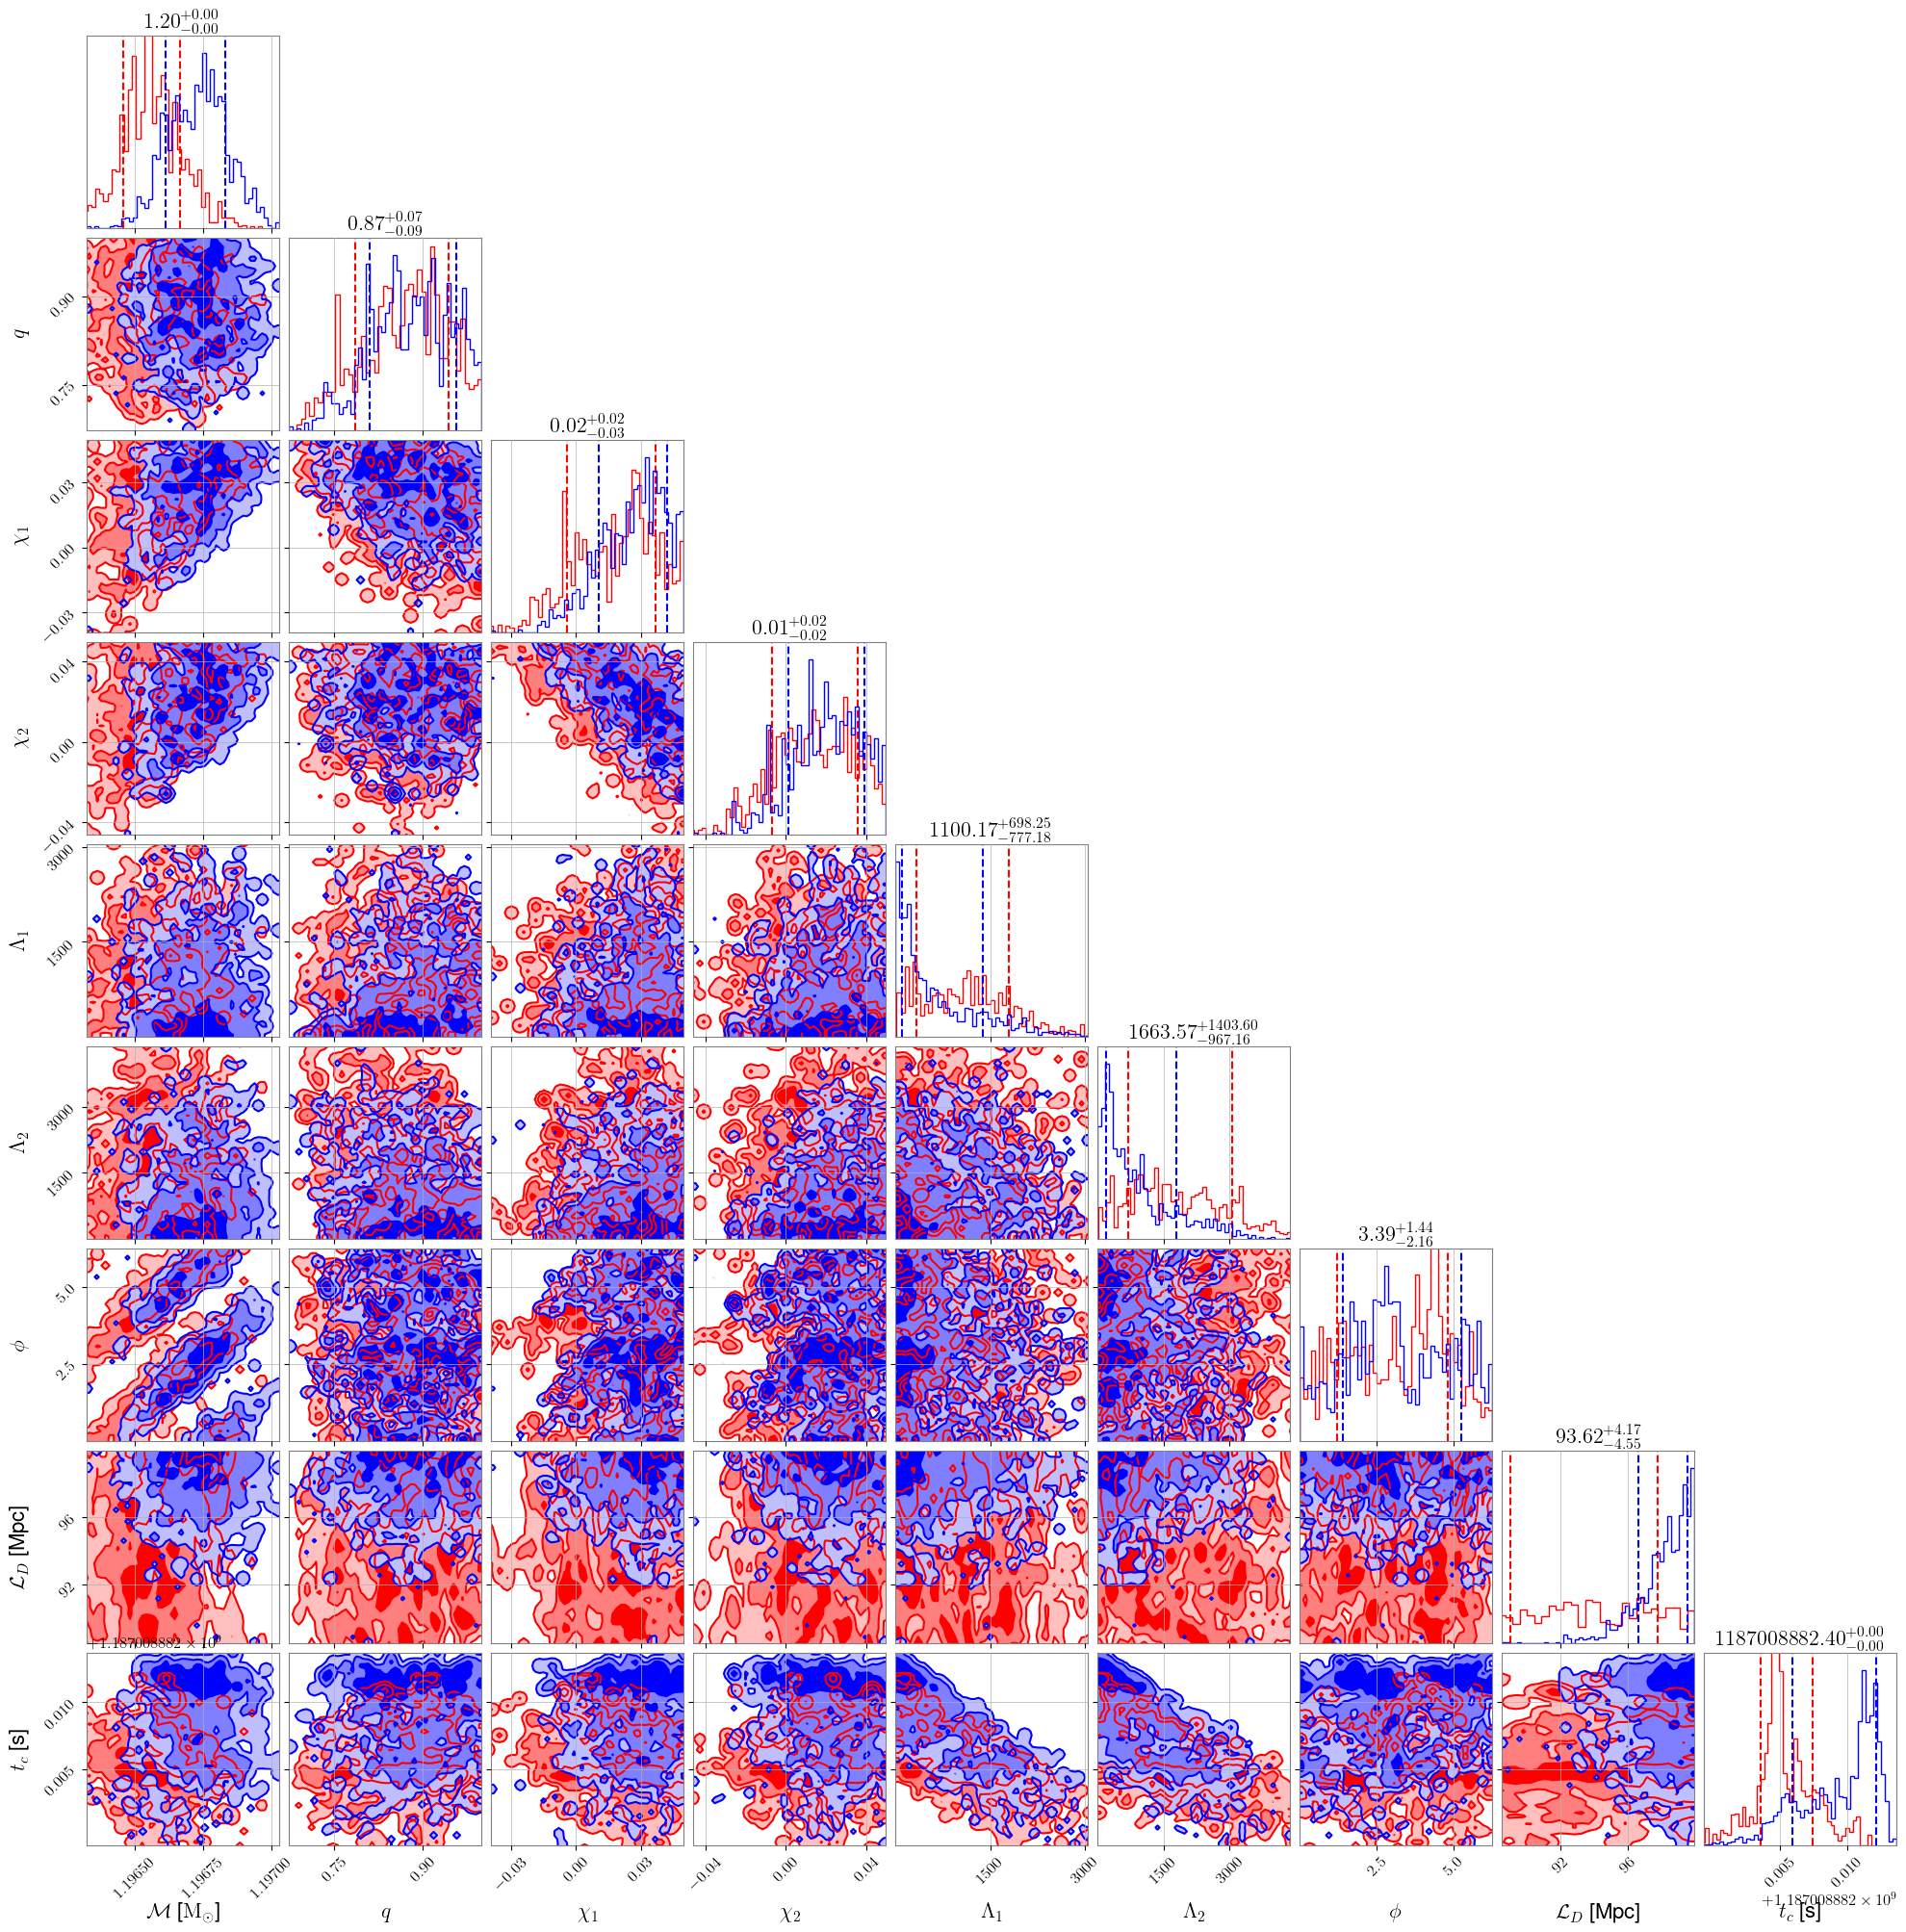

In [4]:
parameters = ['chirp_mass','mass_ratio','chi_1','chi_2','lambda_1','lambda_2','phase','luminosity_distance','geocent_time']
fig = NHP_result.plot_corner(parameters,color='red',save=False)
WFU_result.plot_corner(parameters,fig=fig,color='blue')

With `WFU_result`, we can look at the distributions of the $\varphi$ parameters, of which $\varphi_{3}$-$\varphi_{6}$ have plottable posteriors:

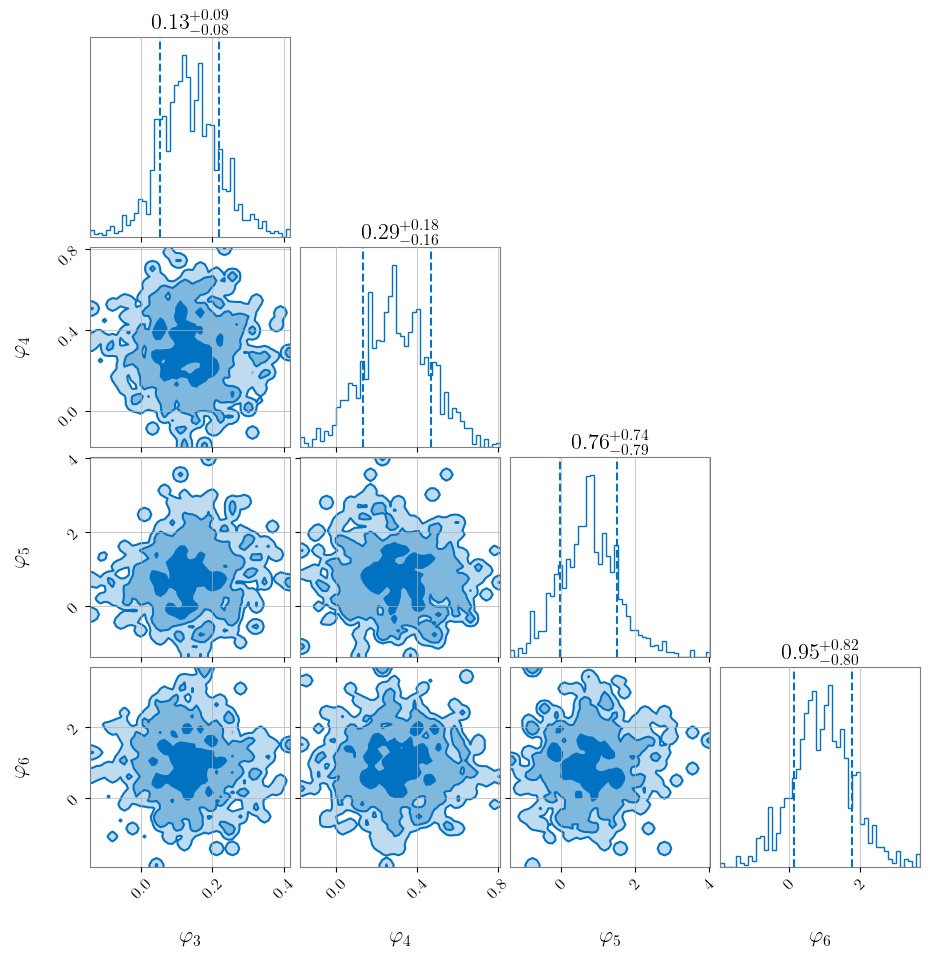

In [5]:
WFU_result.plot_corner(['phi_3','phi_4','phi_5','phi_6'])

## Comparing the Posteriors

Using `WaveformUncertainty.maxL`, we can look at the set of parameters in each posterior that yielded the highest likelihood, or the most likely values of each parameter.

In [7]:
WFU_maxL = wfu.maxL(WFU_result)
WFU_maxL

{'chirp_mass': 1.196654539636273,
 'mass_ratio': 0.8882403683547717,
 'chi_1': 0.03940366935231031,
 'chi_2': -0.009308416173266373,
 'lambda_1': 9.20197903445365,
 'lambda_2': 319.65118168553613,
 'phase': 1.7218332365917133,
 'luminosity_distance': 99.4031710149272,
 'geocent_time': 1187008882.4125783,
 'phi_12': 0.2437146326615714,
 'phi_jl': 1.0169951314613241,
 'theta_jn': 1.7847477925310489,
 'psi': 1.2695709169413083,
 'ra': 3.44616,
 'dec': -0.408084,
 'phi_1': 0.0,
 'phi_2': 0.0,
 'phi_3': 0.17047360511753767,
 'phi_4': 0.16136582942124758,
 'phi_5': 0.8657246700317206,
 'phi_6': 1.178542098811068}

In [8]:
NHP_maxL = wfu.maxL(NHP_result)
NHP_maxL

{'chirp_mass': 1.1965947807373034,
 'mass_ratio': 0.8381136756089695,
 'chi_1': -0.006044175317998786,
 'chi_2': 0.04350209423103893,
 'lambda_1': 322.9919321834844,
 'lambda_2': 328.76485331678253,
 'phase': 4.363570791608241,
 'luminosity_distance': 91.42154839558869,
 'geocent_time': 1187008882.4107683,
 'phi_12': 0.2437146326615714,
 'phi_jl': 1.0169951314613241,
 'theta_jn': 1.7847477925310489,
 'psi': 1.2695709169413083,
 'ra': 3.44616,
 'dec': -0.408084,
 'phi_1': 0.0,
 'phi_2': 0.0}

With these sets of maximum likelihood parameters, we can look at how far off each parameter is from the true (injected) value. First, we need the injected values of the neutron star source parameters.

In [51]:
injected_source_parameters = (NHP_result.meta_data['likelihood']['interferometers']['H1']['parameters']).copy()

# removing the waveform uncertainty parameters
for i in range(6):
    del injected_source_parameters[f'alpha_{i+1}']
    del injected_source_parameters[f'phi_{i+1}']
    
injected_source_parameters

{'chirp_mass': 1.1966109230934618,
 'mass_ratio': 0.9564990689651204,
 'chi_1': 0.04915434732134531,
 'chi_2': -0.031245701787916903,
 'lambda_1': 67.5370608486148,
 'lambda_2': 56.036793938406,
 'phase': 0.7700673357410833,
 'luminosity_distance': 99.74334431393558,
 'geocent_time': 1187008882.412641,
 'phi_12': 0.2437146326615714,
 'phi_jl': 1.0169951314613241,
 'theta_jn': 1.7847477925310489,
 'psi': 1.2695709169413083,
 'ra': 3.44616,
 'dec': -0.408084}

To compare the posteriors, we compare the percent errors of each parameter. We will notate the corrected posterior as `WFU` and the uncorrected posterior as `NHP`.

In [52]:
for parameter in injected_source_parameters.keys():
    NHP_percent_error = np.abs((NHP_maxL[parameter]-injected_source_parameters[parameter])/injected_source_parameters[parameter])*100
    WFU_percent_error = np.abs((WFU_maxL[parameter]-injected_source_parameters[parameter])/injected_source_parameters[parameter])*100
    print(f'Parameter: {parameter} ||| NHP Error: {NHP_percent_error}% ||| WFU Error: {WFU_percent_error}%')

Parameter: chirp_mass ||| NHP Error: 0.001349006251480795% ||| WFU Error: 0.003645006239664569%
Parameter: mass_ratio ||| NHP Error: 12.376948101396204% ||| WFU Error: 7.136306016920732%
Parameter: chi_1 ||| NHP Error: 112.29631893692971% ||| WFU Error: 19.836857776363487%
Parameter: chi_2 ||| NHP Error: 239.2258510508531% ||| WFU Error: 70.20897070436084%
Parameter: lambda_1 ||| NHP Error: 378.24398652389533% ||| WFU Error: 86.37491931270151%
Parameter: lambda_2 ||| NHP Error: 486.6946165373973% ||| WFU Error: 470.4308887422919%
Parameter: phase ||| NHP Error: 466.6479525987046% ||| WFU Error: 123.59515287512966%
Parameter: luminosity_distance ||| NHP Error: 8.343209239259705% ||| WFU Error: 0.34104861968304506%
Parameter: geocent_time ||| NHP Error: 1.57772866453727e-10% ||| WFU Error: 5.2825288195200765e-12%
Parameter: phi_12 ||| NHP Error: 0.0% ||| WFU Error: 0.0%
Parameter: phi_jl ||| NHP Error: 0.0% ||| WFU Error: 0.0%
Parameter: theta_jn ||| NHP Error: 0.0% ||| WFU Error: 0.0%
P

This method of comparing the posteriors is good for looking at the improvement of each parameter, but not good for judging the overall success of the correction.

With `WaveformUncertainty.Q_factor`, we can calculate the overall quality of the correction. This function compares the distance from the maximum likelihood values of each parameter estimation run with the true values of the parameters, which are the injection parameters. $Q=1$ indicates that the correction was perfect and completely removed the waveform differences. $Q>0$ means that the correction improved the accuracy of the posterior. $Q<0$ indicates that the correction did not work and the uncorrected posterior is more accurate.

Here we see $Q=0.2777$, which means that the corrected posterior is 27.77% closer to the true values than the uncorrected posterior.

In [53]:
wfu.Q_factor(WFU_result,NHP_result,true_values)

0.27768896218404926

## Examining the Correction

We can also look at how well the phase difference, $\Delta\Phi$, was recovered during the parameter estimation run.

We first collect the injected $\varphi$ parameters and the recovered, maximum likelihood, $\varphi$ parameters:

In [58]:
injected_source_parameters = (NHP_result.meta_data['likelihood']['interferometers']['H1']['parameters']).copy()
injected_phis = [injected_source_parameters[f'phi_{i+1}'] for i in range(6)]

recovered_phis = [WFU_maxL[f'phi_{i+1}'] for i in range(6)]

We then load in the parameterization file we used to create the waveform uncertainty file before the parameterization runs began. We do this to obtain the phase uncertainty prior, $P(\varphi)$, and the frequency nodes, $f_{k}$.

In [59]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/parameterization_nsamples_1000-4.npy', allow_redirects=True)
open("tutorial_files/parameterization_nsamples_1000.npy", 'wb').write(file.content)

# loading the file
parameterization = np.load("tutorial_files/parameterization_nsamples_1000.npy",allow_pickle=True)

mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty,linear_frequency_grid = wfu.uncertainties_from_parameterization(parameterization,linear=True,resolution=0.1)

_,frequency_nodes = wfu.WFU_prior(mean_amplitude_difference=mean_amplitude_difference,amplitude_uncertainty=amplitude_uncertainty,
                                      mean_phase_difference=mean_phase_difference,phase_uncertainty=phase_uncertainty,spacing='geometric',
                                      frequency_grid=linear_frequency_grid,nnodes=6,prior=None)

We plot the phase difference prior,$P(\varphi)$; injected phase difference, $\Delta\Phi_{\delta}(f;\{f_{k},\varphi_{k}^{inj}\})$; and recovered phase difference, $\Delta\Phi_{\delta}(f;\{f_{k},\varphi_{k}^{ml}\})$:

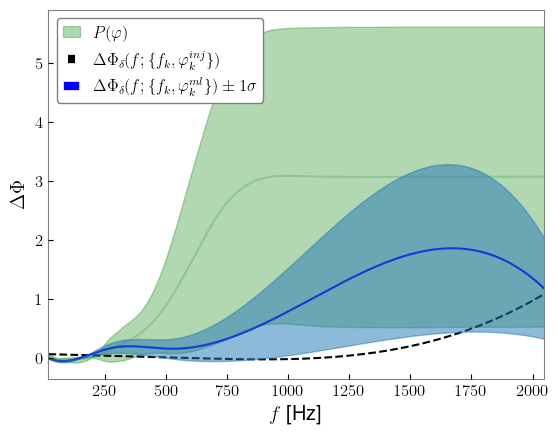

In [89]:
# plotting the prior
plt.plot(linear_frequency_grid,mean_phase_difference,color='green',alpha=0.2)
plt.fill_between(linear_frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='green',alpha=0.3,label=r'$P(\varphi)$')

# plotting injected phase difference
injected_phase_spline = scipy.interpolate.CubicSpline(frequency_nodes,injected_phis)
plt.plot(linear_frequency_grid,injected_phase_spline(linear_frequency_grid),color='k',linestyle='dashed',label=r'$\Delta\Phi_{\delta}(f;\{f_{k},\varphi_{k}^{inj}\})$')

# plotting maximum likelihood phase difference
recovered_phase_spline = scipy.interpolate.CubicSpline(frequency_nodes,recovered_phis)
# finding the standard deviation of each spline node
sigma_phis = [np.std(WFU_result.posterior[f'phi_{i+1}']) for i in range(6)]   
sigma_phase_spline = scipy.interpolate.CubicSpline(frequency_nodes,sigma_phis)

plt.plot(linear_frequency_grid,recovered_phase_spline(linear_frequency_grid),color='blue',zorder=2,
         label=r'$\Delta\Phi_{\delta}(f;\{f_{k},\varphi_{k}^{ml}\})\pm{1}\sigma$')
plt.fill_between(linear_frequency_grid,recovered_phase_spline(linear_frequency_grid)-sigma_phase_spline(linear_frequency_grid),
                 recovered_phase_spline(linear_frequency_grid)+sigma_phase_spline(linear_frequency_grid),color='tab:blue',alpha=0.5,zorder=2)

# plot settings
plt.grid(False)
plt.xlim(linear_frequency_grid[0],linear_frequency_grid[-1])
plt.xlabel(r'$f$'+' [Hz]')
plt.ylabel(r'$\Delta\Phi$')
plt.tick_params(direction='in')
plt.legend(fancybox=True,framealpha=1,loc='upper left')
plt.show()